In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

## Instructions:
#### 1) Choose angle and particle in cell below
#### 2) Set Angle range
#### 3) Set weighting range, draw the histograms and look at the fits.
#### 4) Ignore the histograms that aren't Gaussian, fit those that are. Feel free to change weighting range and initial fit parameters "p0" to get the best fits.
#### Note: If you get a numpy warning while fitting, likely need to adjust initial parameters
#### Note: If a drawn histogram doesn't have a fit curve with it, it wasn't able to be fit by a Gaussian. It probably isn't Gaussian in shape, but if it is, can try to play with fit settings.
#### Note: Drawing only draws a portion of the weights (first 50 histograms)
#### 5) Set "draw" to false to go through the entire weighting range


### Get data, transform ROOT tree into array

In [2]:
# Parameters 
energy = 1  #Energy in GeV. Available energies are 1, 2, 5, 10, 20, 50 GeV.
particle = 'pi+' # Particle incident on detectors

# Code to get all the files from the xrootd server
#files = [] # List to contain all the data file names
# Loop through some large number to obtain all the available files so we don't have to look them up manually. 
# for file_number in range(1, 101):
#     try:
#         file_name = 'root://sci-xrootd.jlab.org//osgpool/eic/ATHENA/RECO/SINGLE/{particle}\
# /{energy}GeV/3to50deg/{particle}_{energy}GeV_3to50deg.{file_number:04d}.root:events'.format(energy = energy, particle = particle, file_number = file_number)
#         ur.open(file_name) # Open each file. If the file doesn't exist, it will be skipped and not be added to files list.
#         files.append(file_name)
#     except:
#         continue

# print("Number of files: {NumFiles}.".format(NumFiles = len(files)))

# Using file Miguel just produced
files = '/home/ryan/EIC_Data/rec_{particle}_forward.root:events'.format(particle = particle)
#files = 'root://sci-xrootd.jlab.org//osgpool/eic/ATHENA/RECO/SINGLE/{particle}/{energy}GeV/3to50deg/{particle}_{energy}GeV_3to50deg.0002.root:events'.format(energy = energy, particle = particle)

# Combining all the data files that we found. Only include the branches that are of interest
full_events = ur.concatenate(files, ["mcparticles2.psx", "mcparticles2.psy", "mcparticles2.psz", "mcparticles2.pdgID", "mcparticles2.genStatus"], library = 'np')
EcalP_events = ur.concatenate(files, ["EcalEndcapPHitsReco.energy"], library = 'np')
HcalHadron_events = ur.concatenate(files, ["HcalHadronEndcapHitsReco.energy"], library = 'np')

In [3]:
if len(full_events['mcparticles2.pdgID']) != len(HcalHadron_events["HcalHadronEndcapHitsReco.energy"]) or len(full_events['mcparticles2.pdgID']) != len(EcalP_events["EcalEndcapPHitsReco.energy"]):
    raise ValueError("Number of events do not align!")
num_events = len(full_events['mcparticles2.pdgID'])
print('Number of events: {events}'.format(events=num_events))

Number of events: 10000


10000 total events
0 empty events
10000 nonempty events


Text(0, 0.5, 'Number of Events')

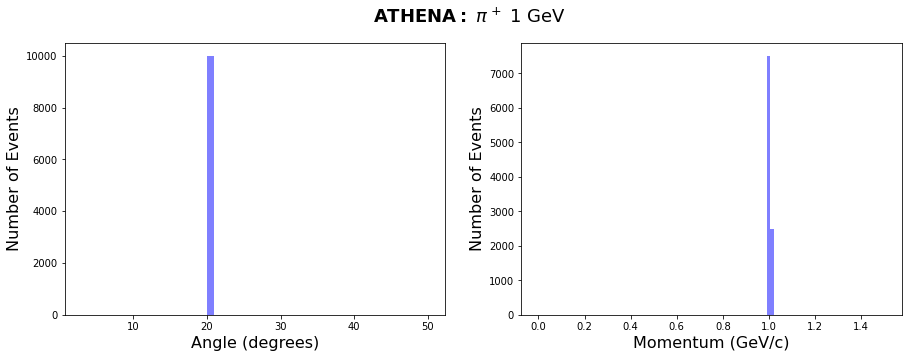

In [4]:
# Getting the incident angle and momentum for each event

theta_list = []
momentum_list = []
num_empty_events = 0
particle_ids = {'pi+':211, 'pi0':111, 'e-':11, 'e+':-11, 'gamma':22, 'n':2112, 'p':2212} # MC particle ids

# Looping over each event to get angle and momentum of incident particle
for i in range(num_events):
    num_particles = len(full_events["mcparticles2.pdgID"][i])
    if num_particles == 0:
        num_empty_events += 1
        theta_list.append(-999) # Will count for the total number of events but keeps the empty events out of consideration
        momentum_list.append(-999)
        continue
    for j in range(num_particles):
        if full_events["mcparticles2.pdgID"][i][j] != particle_ids[particle]:
            continue
        # Note: genStatus doesn't work for online data files, uncomment break statement instead for these
        if full_events["mcparticles2.genStatus"][i][j] != 1: # genStatus of 1 is final state particle. I think this is what we want?
            continue
        px = full_events["mcparticles2.psx"][i][j]
        py = full_events["mcparticles2.psy"][i][j]
        pz = full_events["mcparticles2.psz"][i][j]
        p = np.sqrt(px*px + py*py + pz*pz)
        momentum_list.append(p)
        theta = np.arccos(pz/p)*180/np.pi
        theta_list.append(theta)
        #break # First POI in each event is assumed to be incident particle. Use for online files since can't identify particle from genStatus.
        

print("{total} total events".format(total=len(theta_list)))
print("{empty} empty events".format(empty=num_empty_events))
print("{nonempty} nonempty events".format(nonempty=num_events - num_empty_events))

plt.figure(figsize=(15,5))
plt.suptitle(r"$\bf{ATHENA:}$"+' $\pi^+$ {energy} GeV'.format(energy=energy), fontsize=18)

plt.subplot(1,2,1)
theta_data, theta_bins, _ = plt.hist(theta_list, 47, (3, 50), density=False, facecolor='b', alpha=.5)

plt.xlabel("Angle (degrees)", fontsize = 16)
plt.ylabel("Number of Events", fontsize = 16)

plt.subplot(1,2,2)
momentum_data, momentum_bins, _ = plt.hist(momentum_list, 100, (0, 1.5), density=False, facecolor='b',alpha=.5)
plt.xlabel("Momentum (GeV/c)", fontsize = 16)
plt.ylabel("Number of Events", fontsize = 16)

In [5]:
def Angle_Energy(detector_events = HcalHadron_events, detector_name = "HcalHadronEndcapHitsReco", event_angles = theta_list, desired_low_angle = 5, desired_high_angle = 10):
    num_events = len(event_angles)
    energies = []
    for i in range(num_events):
        event_angle = event_angles[i]
        if event_angle >= desired_low_angle and event_angle < desired_high_angle:
            energies.append(detector_events["{detector}.energy".format(detector = detector_name)][i])
    return energies

### Choosing Angle Range

In [6]:
# If you want a specific angle range, set filter_angle to True and input angle range into angle variables. Will select events with angles in range [low, high)
filter_angle = True
low_angle = 20
high_angle = 21

Hcal_energies = []
Ecal_energies = []
if filter_angle:
    Hcal_energies = Angle_Energy(HcalHadron_events, "HcalHadronEndcapHitsReco", theta_list, low_angle, high_angle)
    Ecal_energies = Angle_Energy(EcalP_events, "EcalEndcapPHitsReco", theta_list, low_angle, high_angle)
else:
    Hcal_energies = HcalHadron_events["HcalHadronEndcapHitsReco.energy"]
    Ecal_energies = EcalP_events["EcalEndcapPHitsReco.energy"]

num_desired_events = len(Ecal_energies)
print("Considering {X} events".format(X = num_desired_events))

Considering 10000 events


### Setting up weight histograms

In [7]:
# Weighting the ecal energies and adding to histograms
draw = False

initial_weights_for_energies = {1:1.0, 2:1.5, 5:2.0, 10:4.0, 20:3.0, 50: 4.0}
w0 = initial_weights_for_energies[energy]
weights = np.array([],float)
draw_counts = 0
while w0 <= 15.0 and draw_counts < 50:
    weights = np.append(weights, w0)
    w0 += 0.1
    if draw:
        draw_counts += 1
EW = [] # EW will hold the weighted total energies for each weight in "weights"
for i in range(len(weights)):
    EW.append([])
    
for i in range(num_desired_events):
    hcal_edep = np.sum(Hcal_energies[i])*1000
    ecal_edep = np.sum(Ecal_energies[i])*1000
    for j in range(len(weights)):
        weighted_energy = ecal_edep/weights[j]+hcal_edep
        EW[j].append(weighted_energy)

### Fitting and choosing optimal weight
#### Set "fit" to true to fit, set "draw" to true in cell above to draw sample of histograms from above cell (Warning: Drawing takes a little bit of time)

In [8]:
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaussian(x, A, mean, variance):
    return A * np.exp(-0.5*((x - mean)**2 /variance)) # Make sure to take sqrt of variance parameter to get sigma

max_energies = {1:500.5, 2:400.5, 5:800.5, 10:1000.5, 20:3000.5, 50:2500.5}

min_resolution = 999999
min_index = -9999
num_bins = round((max_energies[energy]-0.5)/1)
bin_width = (max_energies[energy]-0.5)/num_bins
resolutions = np.array([],float)

print("Number of bins: {bins}".format(bins=num_bins))
print("Bin width: {bin_width} MeV.".format(bin_width=bin_width))

max_rows = 10
max_cols = 5

fit = True

ignore_hists = 0
if ignore_hists != 0:
    print("Ignoring first {X} histograms.".format(X = ignore_hists))

if draw:
    fig = plt.figure(figsize = (40,40))
    fig.subplots_adjust(hspace = .5)

for i in range(ignore_hists,len(EW)):
    if draw:
        
        plt.subplot(max_rows, max_cols, i+1)   
        hist_data, bins, _ = plt.hist(EW[i], num_bins, (0.5, max_energies[energy]))
        plt.title("Weight: {weight_val}".format(weight_val = round(weights[i],2)))
        plt.xlabel("Energy (MeV)")
        plt.ylabel("Counts")
    else:
        hist_data, bins = np.histogram(EW[i], num_bins, (0.5, max_energies[energy]+.5))

    bin_centers = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

    if fit:
        amp = 0
        amp_x = 0
        for k in range(len(hist_data)):
            if hist_data[k] >=amp:
                amp = hist_data[k]
                amp_x = bin_centers[k]
        try:
            popt, pcov = curve_fit(gaussian, xdata=bin_centers, ydata=hist_data, p0=(amp,amp_x, 10))
        except:
            continue
        weight_resolution = np.sqrt(popt[2])/popt[1]
        resolutions = np.append(resolutions, weight_resolution)
        if weight_resolution < min_resolution:
           min_resolution = np.abs(weight_resolution)
           min_index = i
        if draw:
            plt.plot(bin_centers, gaussian(bin_centers, *popt))
            max_bin_height = 0
            for j in range(len(hist_data)):
               if hist_data[j] > max_bin_height:
                   max_bin_height = hist_data[j]
            plt.text(0.8*max_energies[energy]+.5, 0.6*max_bin_height, "A= {amp} \n $\mu$ = {mean} \n $\sigma$ = {sigma} \n $\sigma/\mu$ = {res}"\
                     .format(amp = round(popt[0],2), mean = round(popt[1],2), sigma = round(np.sqrt(popt[2]),3), res = round(weight_resolution,4)),horizontalalignment='center',multialignment='left',verticalalignment='center', fontsize = 16)

if fit:
    print("Index in array: {index}".format(index = min_index))
    print("Minimum resolution is {res} using weight {weight}.".format(res = round(min_resolution,3), weight = round(weights[min_index],2)))


Number of bins: 500
Bin width: 1.0 MeV.
Index in array: 89
Minimum resolution is 0.242 using weight 9.9.


Text(375.875, 478.09999999999997, '\n Weight = 9.9 \n Bin width = 1.0 MeV \n A = 643.37 \n $\\mu$ = 24.28 \n $\\sigma$ = 5.876 \n $\\sigma/\\mu$ = 0.24204')

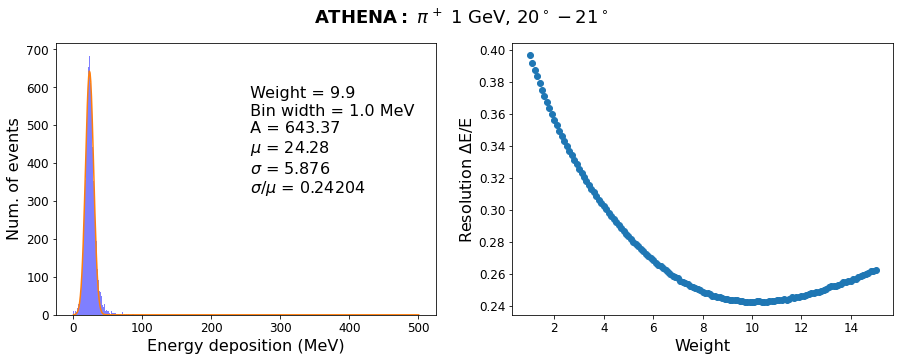

In [9]:
# Plotting the histogram with the optimal weight

fig = plt.figure(figsize=(15,5))

fig.suptitle(r"$\bf{ATHENA:}$"+' $\pi^+$ {energy} GeV, ${low_angle}^{degrees}-{high_angle}^{degrees}$'.format(energy=energy, low_angle = low_angle, high_angle = high_angle, degrees = "\circ"), fontsize=18)

plt.subplot(1,2,2)
plt.scatter(weights, resolutions)
#plt.title(r"$\bf{ATHENA:}$"+' $\pi^+$ {energy} GeV, ${low_angle}^{degrees}-{high_angle}^{degrees}$'.format(energy=energy, low_angle = low_angle, high_angle = high_angle, degrees = "\circ"), fontsize=18)
plt.xlabel("Weight", fontsize = 16)
plt.ylabel("Resolution $\Delta$E/E", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(1,2,1)
hist_data, bins, _ = plt.hist(EW[min_index], num_bins, (0.5, max_energies[energy]+.5), density=False, facecolor='b', alpha=.5)

bin_centers = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
amp = 0
amp_x = 0
for i in range(len(hist_data)):
    if hist_data[i] >= amp:
        amp = hist_data[i]
        amp_x = bin_centers[i]
popt, pcov = curve_fit(gaussian, xdata=bin_centers, ydata=hist_data, p0=(amp,amp_x,10))
max_bin_height = 0
for i in range(len(hist_data)):
    if hist_data[i] > max_bin_height:
        max_bin_height = hist_data[i]

plt.plot(bin_centers, gaussian(bin_centers, *popt))
plt.xlabel("Energy deposition (MeV)", fontsize = 16)
plt.ylabel("Num. of events", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.text(0.75*max_energies[energy]+.5, 0.7*max_bin_height, "\n Weight = {weight} \n Bin width = {width} MeV \n A = {amplitude} \n $\mu$ = {mean} \n $\sigma$ = {sigma} \n $\sigma/\mu$ = {res}".format(weight = round(weights[min_index],2), width = bin_width ,amplitude = round(popt[0],2), mean = round(popt[1],2), sigma = round(np.sqrt(popt[2]),3), res = round(np.sqrt(popt[2])/popt[1],5)),horizontalalignment='center',multialignment='left',
                 verticalalignment='center', fontsize = 16)

## Old results for bad data files

In [ ]:
energies = np.array([1,2,5,10,20,50],float)
energies = 1/np.sqrt(energies)

resolutions = np.array([0.69303, 0.61837, 0.96407, 1.03824, 0.98425,0.94833])
plt.scatter(energies, resolutions)
plt.xlabel("1/$\sqrt{E (GeV)}$", fontsize=16)
plt.ylabel("Resolution $\Delta$E/E", fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title(r"$\bf{ATHENA:}$"+' $\pi^+$, ${low_angle}^{degrees}-{high_angle}^{degrees}$'.format(low_angle = low_angle, high_angle = high_angle, degrees = "\circ"), fontsize=18)

In [ ]:
energy_list = np.array([1,2,5,10, 20, 50])
#events_list = np.array([100020, 80016, 80032, 100080, 100080, 100200])
events_list = np.array([100000, 80000, 80000, 100000, 100000, 100000])
events_at_20 = np.array([1698,1421,1334,1747, 1777, 1750])

events_percentage = np.divide(events_at_20,events_list)
events_percentage *= 100
print(events_percentage)
fig = plt.figure(figsize=(15,5))

fig.suptitle(r"$\bf{ATHENA:}$"+' $\pi^+$',fontsize=18)
plt.subplot(1,2,1)
plt.bar(energy_list, events_list, color = 'b')
plt.bar(energy_list, events_at_20, color = 'r')
plt.xlabel("Incident energy (GeV)", fontsize = 16)
plt.ylabel("Number of events", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(labels=["3-50 deg", "20-21 deg"], fontsize = 16)
# ax = fig.add_axes([0,0,1,1])
# ax.bar(energy_list, events_list, color = 'b')
# ax.bar(energy_list, events_at_20, color = 'r')
# ax.set_xlabel("Incident energy (GeV)")
# ax.set_ylabel("Number of events")
# ax.legend(labels=["3-50 deg", "20-21 deg"])

plt.subplot(1,2,2)
plt.bar(energy_list, events_percentage)
plt.xlabel("Incident energy (GeV)", fontsize=16)
plt.ylabel("Percentage of events", fontsize = 16)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.title("Percentage of events at 20-21 deg", fontsize = 16)
plt.ylim(1.6,2)
